# HOG detectMultiScale parameters explained

### Accessing the HOG detectMultiScale parameters

In [1]:
import cv2

In [2]:
help(cv2.HOGDescriptor().detectMultiScale)

Help on built-in function detectMultiScale:

detectMultiScale(...) method of cv2.HOGDescriptor instance
    detectMultiScale(img[, hitThreshold[, winStride[, padding[, scale[, groupThreshold[, useMeanshiftGrouping]]]]]]) -> foundLocations, foundWeights
    .   @brief Detects objects of different sizes in the input image. The detected objects are returned as a list
    .       of rectangles.
    .       @param img Matrix of the type CV_8U or CV_8UC3 containing an image where objects are detected.
    .       @param foundLocations Vector of rectangles where each rectangle contains the detected object.
    .       @param foundWeights Vector that will contain confidence values for each detected object.
    .       @param hitThreshold Threshold for the distance between features and SVM classifying plane.
    .       Usually it is 0 and should be specified in the detector coefficients (as the last free coefficient).
    .       But if the free coefficient is omitted (which is allowed), you c

1. El Problema: El mundo real no es 64×128

- La realidad: En una cámara de seguridad o una foto cualquiera, las personas pueden estar lejos (pequeñas) o cerca (grandes).
- El desafío: Un detector HOG manual solo sabe buscar ventanas de tamaño fijo. Si la persona es más grande o más pequeña que la ventana, el detector falla.

2. La Solución: detectMultiScale (La Pirámide)

- Esta función hace el trabajo sucio por ti. En lugar de cambiar el tamaño de la ventana de detección, cambia el tamaño de la imagen repetidamente.
  - Toma la imagen original → Busca personas.
  - Reduce la imagen un poco → Busca personas.
  - Reduce la imagen otro poco → Busca personas.
  - Repite hasta que la imagen sea minúscula.
- Esto se llama Pirámide de Imágenes . Permite detectar personas de cualquier tamaño usando el mismo detector de ventana fija.

3. El Triángulo de la Muerte (Lo que vamos a ajustar)

- El texto introductorio advierte que esta "magia" tiene un coste. Vamos a tener que ajustar perillas (parámetros) para equilibrar tres fuerzas opuestas:
  - Falsos Positivos (False Positives): Decir que hay una persona en una sombra o un árbol. (Demasiada sensibilidad).
  - Falsos Negativos (Missed Detections): No ver a la persona que está ahí. (Poca sensibilidad).
  - Velocidad (FPS): Si revisas demasiadas escalas o mueves la ventana muy lento, el programa se arrastra y no sirve para video en tiempo real (especialmente en hardware limitado como una Raspberry Pi).

### HOG detectMultiScale parameters explained

In [ ]:
# importar los paquetes necesarios
from __future__ import print_function
import argparse
import datetime
import imutils
import cv2
# construir el analizador de argumentos y parsear los argumentos
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=True,
	help="ruta a la imagen de entrada")
ap.add_argument("-w", "--win-stride", type=str, default="(8, 8)",
	help="paso de ventana")
ap.add_argument("-p", "--padding", type=str, default="(16, 16)",
	help="relleno del objeto")
ap.add_argument("-s", "--scale", type=float, default=1.05,
	help="escala de la pirámide de imágenes")
ap.add_argument("-m", "--mean-shift", type=int, default=-1,
	help="si se debe usar agrupamiento mean shift o no")
args = vars(ap.parse_args())

# El paso de la ventana. ¿Cuánto se mueve la ventana verde cada vez?
winStride = eval(args["win_stride"])

# El margen. Cuánto espacio extra añadimos alrededor de la imagen antes de procesarla.
padding = eval(args["padding"])
meanShift = True if args["mean_shift"] > 0 else False

# inicializar el descriptor HOG/detector de personas
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# cargar la imagen y redimensionarla
image = cv2.imread(args["image"])
image = imutils.resize(image, width=min(400, image.shape[1]))

# detectar personas en la imagen
start = datetime.datetime.now()
(rects, weights) = hog.detectMultiScale(image, winStride=winStride,
	padding=padding, scale=args["scale"], useMeanshiftGrouping=meanShift)
print("[INFO] la detección tomó: {}s".format(
	(datetime.datetime.now() - start).total_seconds()))

# dibujar los cuadros delimitadores originales
for (x, y, w, h) in rects:
	cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# mostrar la imagen de salida
cv2.imshow("Detecciones", image)
cv2.waitKey(0)

1. img (El Requisito)

- Este es el único parámetro obligatorio.
- Qué es: Simplemente la matriz de la imagen donde quieres buscar a la gente.
- Dato útil: Puede ser tanto en color como en escala de grises. El detector funciona igual.


2. hitThreshold (El Oscuro)

- Este es un parámetro opcional que casi nadie toca, y el autor explica por qué.
- ¿Qué es conceptualmente? Imagina que el SVM es un juez que traza una línea en el suelo. A un lado están los "Peatones" y al otro el "Fondo".
  - Algunas detecciones caen muy lejos de la línea (el juez está 100% seguro).
  - Otras caen justo al borde (el juez duda).
- El hitThreshold es un filtro de confianza. Controla la distancia máxima permitida entre las características que extrajiste (HOG) y esa línea de decisión (el plano clasificador del SVM).
  - Si la distancia excede este umbral → La detección se rechaza (se considera demasiado dudosa o ruido).
  - Si está por debajo → Se acepta.
- El Veredicto del Experto: No lo uses.

3. winStride, que es probablemente el parámetro más crítico para controlar la velocidad.

- El Concepto: El "Paso" del Escáner
  - Imagina que estás buscando algo perdido en el suelo con una linterna (la ventana deslizante).
  - winStride define qué tan largos son tus pasos al mover la linterna.
    - ¿Mueves la linterna centímetro a centímetro? (Paso corto).
    - ¿Das saltos grandes? (Paso largo).
  - Matemáticamente, es una tupla (x, y) que dice cuántos píxeles se mueve la ventana a la derecha y hacia abajo en cada iteración.

- El Dilema: Velocidad vs. Precisión

    - Cada vez que la ventana se detiene, la computadora tiene que hacer todo el trabajo pesado que aprendiste antes (calcular gradientes, histogramas, SVM).
        - Caso A: Pasos Cortos (4, 4)
            - 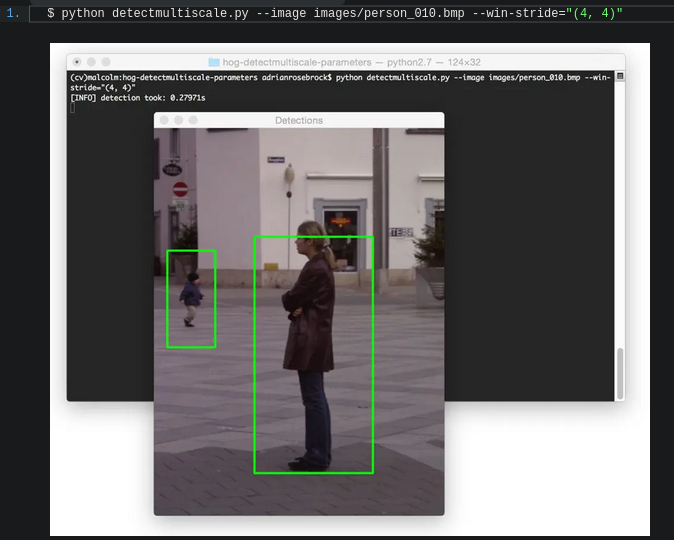
            - Comportamiento: La ventana se solapa mucho. Analizas casi cada píxel posible.
            - Ventaja: Es muy difícil que se te escape alguien. Tienes máxima precisión.
            - Desventaja: Es lento.
            - Ejemplo del texto: El tiempo subió de 0.09s a 0.27s (casi el triple).
        - Caso B: Pasos Largos (16, 16)
            - 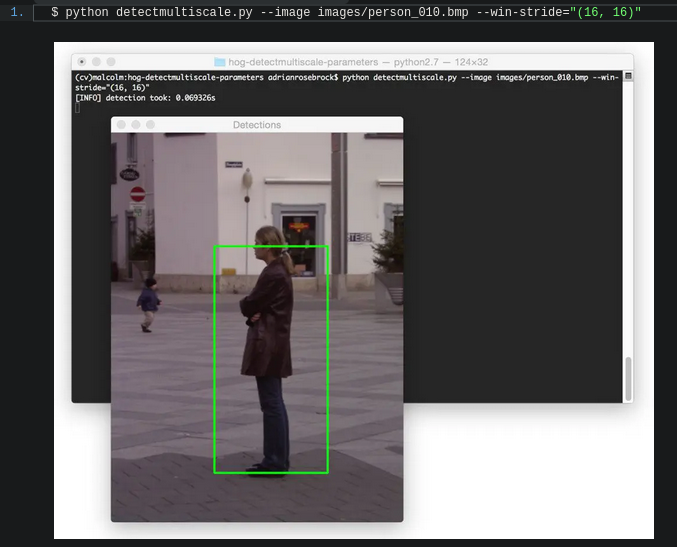
            - Comportamiento: La ventana da saltos grandes.
            - Ventaja: Es muy rápido.
            - Ejemplo del texto: El tiempo bajó a 0.06s.
            - Desventaja: Puedes "saltarte" a una persona si cae justo en el hueco entre dos pasos.
            - Fallo real: En el ejemplo, al usar pasos grandes, el detector no vio al niño que estaba en el fondo porque la ventana saltó sobre él.

- La Recomendación del Autor
  - Adrian Rosebrock sugiere una estrategia pragmática:
    - Empieza con (4, 4) para asegurar que detectas todo bien.
    - Si tu programa va muy lento (pocos FPS), ve subiendo el número poco a poco hasta que encuentres el equilibrio.
- En resumen:
  - winStride bajo = Lento pero seguro.
  - winStride alto = Rápido pero "miope".

4. padding

- El Concepto: "Espacio para respirar"
    - El parámetro padding es simplemente un margen extra de píxeles que se añade alrededor de cada ventana de detección antes de analizarla.
    - Sin padding: El algoritmo analiza el recorte exacto. Si la persona está muy pegada al borde, se pierde información de contexto.
    - Con padding: Se añade un borde (relleno) alrededor. Esto le da al algoritmo un poco de contexto sobre qué hay justo al lado de la persona.

- ¿Por qué mejora la precisión?

    - Puede parecer irrelevante, pero los creadores de HOG (Dalal y Triggs) descubrieron en su paper original que añadir este margen aumenta la precisión.
    - La razón: Al incluir un poco del fondo que rodea al sujeto, los gradientes del contorno de la persona se definen mejor. El algoritmo puede ver dónde termina la persona y dónde empieza el fondo, en lugar de cortar abruptamente.

- Valores Típicos

    - Es una tupla (x, y) que indica cuántos píxeles añadir. Los valores comunes son múltiplos de 8 (porque las celdas HOG son de 8×8):
        - (8, 8)
        - (16, 16)
        - (24, 24)
        - (32, 32).

- Recomendación: Generalmente, un valor intermedio como (16, 16) suele ser suficiente para ganar esa precisión extra sin complicaciones.

5. scale

- Este parámetro controla la Pirámide de Imágenes.
- El Concepto: La Pirámide
    - Como vimos antes, HOG tiene una ventana de tamaño fijo (64×128). Si una persona es gigante o minúscula en tu foto, la ventana no encajará.
    - Solución: En lugar de cambiar la ventana, cambiamos el tamaño de la foto repetidamente.
    - El parámetro scale: Define cuánto se encoge la imagen en cada paso hacia arriba de la pirámide.

- Cómo funcionan los valores (Matemática inversa)
    - El valor es un factor de reducción.
    - scale = 1.05 (Valor típico): Significa que la nueva capa es un 5% más pequeña que la anterior. (Reduce poco a poco).
    - scale = 1.5 (Valor agresivo): Significa que la nueva capa es un 50% más pequeña. (Reduce de golpe).

- El Impacto (Velocidad vs. Precisión)
    - Caso A: Escala Pequeña (1.01 a 1.05)
        - Comportamiento: La imagen se reduce muy lentamente. Se crean muchísimas capas en la pirámide (cientos de versiones de la foto).
        - Ventaja: Máxima precisión. Detectas personas de cualquier tamaño posible.
        - Desventaja: Lentitud extrema.
            - Ejemplo del texto: Con scale=1.01, el tiempo saltó a 0.3s.
            Efecto secundario: Aparecen muchas cajas superpuestas (que luego limpias con NMS).
    - Caso B: Escala Grande (1.5 o más)
        - Comportamiento: La imagen se reduce drásticamente en pocos pasos. La pirámide tiene muy pocas capas.
        - Ventaja: Velocidad extrema.
            - Ejemplo del texto: Con scale=1.5, el tiempo bajó a 0.02s (¡50 FPS!).
        - Desventaja: Riesgo alto de "saltarse" una escala. Si la persona tenía un tamaño intermedio que desapareció al reducir la foto de golpe, no la detectarás.

- La combinación "Mortal"

    - El texto advierte sobre combinar winStride pequeño (ej. 4x4) con scale pequeño (ej. 1.03).
    - Esto es "fuerza bruta" pura. Analizas cada píxel de cientos de capas.
    - Resultado: Tarda medio segundo por foto (0.5s). Totalmente inútil para video en tiempo real, aunque detecte absolutamente todo.

6. finalThreshold (El Fantasma)

- Este es un caso curioso en el mundo de la programación: un parámetro que existe pero nadie sabe exactamente qué hace.
- La situación: Adrian Rosebrock admite honestamente que no tiene idea de qué hace este parámetro en la versión de Python, ni siquiera está claro en la documentación oficial.
- La especulación: Probablemente sea un filtro final para eliminar falsos positivos (similar al hitThreshold), pero sin documentación, es jugar a la ruleta rusa.
- El consejo: Ignóralo por completo. No lo pongas en tu código. Si el experto no lo usa, tú tampoco deberías preocuparte por él.

7. useMeanShiftGrouping (La Trampa)

- Este parámetro es una "trampa" para principiantes. Su nombre suena genial ("Agrupamiento por desplazamiento de media"), pero el autor es tajante: "En mi opinión, nunca debería establecerse en True".
- El Problema: La Lluvia de Cajas Cuando el detector HOG funciona bien, no detecta a la persona una sola vez. La detecta muchas veces seguidas porque la ventana se mueve poco a poco y "ve" a la persona en varias posiciones ligeramente distintas.
- Resultado: Terminas con 5 o 6 cajas rodeando a la misma persona.
- La Solución Real: NMS (Non-Maxima Suppression) En lugar de usar ese parámetro interno defectuoso, la industria estándar usa una técnica externa llamada Non-Maxima Suppression (NMS).
    - Cómo funciona: Mira todas las cajas superpuestas, elige la que tiene mayor puntuación de confianza (la "mejor" detección) y borra todas las demás que se superpongan demasiado con ella.
    - Ventaja: Es más rápido y mucho más preciso que el Mean Shift.

- Resumen Final de Parámetros

| Parámetro | Veredicto |
| --- | --- |
| img | **Obligatorio**. Tu imagen (color o gris). |
| hitThreshold | **Ignorar**. Deja que el valor por defecto trabaje. |
| winStride | **Crítico**. (4,4) es lento/preciso, (8,8) es rápido. Tu palanca principal de FPS. |
| padding | **Útil**. Usa (16,16) para dar contexto y mejorar la precisión. |
| scale | **Crítico**. 1.05 es el estándar. Sube a 1.1+ solo si necesitas mucha velocidad. |
| finalThreshold | **Ignorar**. Nadie sabe qué hace realmente. |
| useMeanShiftGrouping | **Apagar**. Siempre en False. Usa NMS después. |


# Tarea

## Ejemplo 1

- Imagen original:
    - 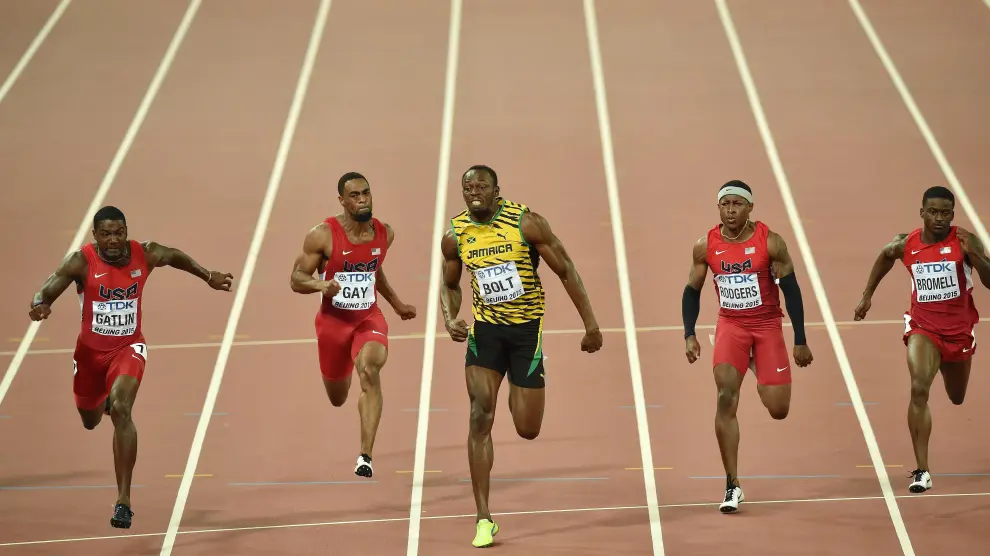
- Ejecución con parámetros por defecto:
    - **python detect.py --image carrera.png**
    - 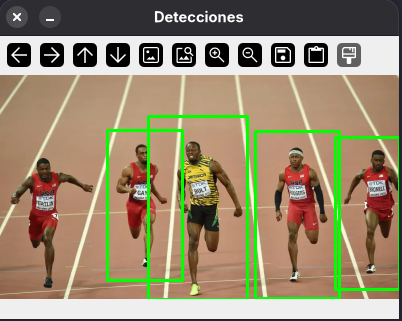
- Ejecución con parámetros ajustados:
    - **python detect.py --image carrera.png --win-stride="(4, 4)" --padding="(16, 16)"**
    - 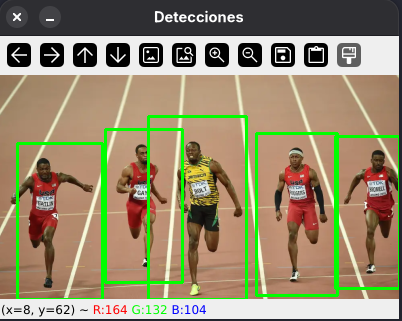
    - Se reduce el paso a la mitad (4, 4) para escanear cada rincón de la imagen.


- Los 3 Mandamientos de la Optimización, aplicados a lo que acabamos de vivir:

1. El Tamaño Importa (Resize)
    - El consejo: Redimensiona tu imagen lo más pequeña posible antes de detectar.
    - La lección: No hay un número mágico. Para una cámara de seguridad en un pasillo, 400px sobra. Para una foto de estadio, necesitas 1000px o más.

2. Las Palancas de Velocidad (scale y winStride)
    - El consejo: Mantén estos valores lo más altos posible (pasos grandes) siempre que la precisión aguante.
    - La estrategia: En un sistema real, empiezas con valores altos (rápido) y solo los bajas si detectas que estás perdiendo objetos.

3. La Opción Nuclear (C/C++)
    - El consejo: Si Python no da más de sí (porque Python es lento por naturaleza), reescribe el código en C++.